# Machine Learning - TP2: Detectando lugares del mundo

### Dependencias

In [33]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

import matplotlib.pyplot as plt
# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.optimizers import Adam

### Origen de datos

En sí contamos con train y test, pero para poder analizar el resultado del entrenamiento, tomamos el 20% de las imágenes de train de forma aleatoria para crear un directorio de validation (el script utilizado se encuentra en la raíz del repositorio como create_validation.py)

In [2]:
# Fede: /media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/
# Andy: C:/Users/andru/Downloads/ucse-ia-2024-tp-2-clasificacion-de-imagenes/
BASE_DIR = '/media/federico/secondary/Repositorios/UCSE/MachineLearning/data_tp2/'

TRAIN_DIR = Path(BASE_DIR + 'train')
VALIDATION_DIR = Path(BASE_DIR + 'validation')

### Variables Globales

In [3]:
CLASES = "street", "sea", "mountain", "glacier", "forest", "buildings"

#### Parámetros a probar

In [4]:
# Al principio probamos con un SIZE de 32, pero consideramos incrementarlo a 64 para que tenga más detalle
SIZE = 64

### Leer imágenes de entrada

In [5]:
images_reader = ImageDataGenerator(
    rescale=1/255, #para que el valor del pixel vaya entre 0 y 1
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    #horizontal_flip=True,
    #vertical_flip=True,
)

READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=CLASES,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),  # para que corra más rápido, vamos a achicar las imágenes
    color_mode="rgb",  # queremos trabajar con las imágenes a color
)

In [6]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


Definimos una función para mostrar ejemplos de imagenes del dataset

In [7]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(CLASES[np.argmax(labels[i])])
        plt.axis("off")

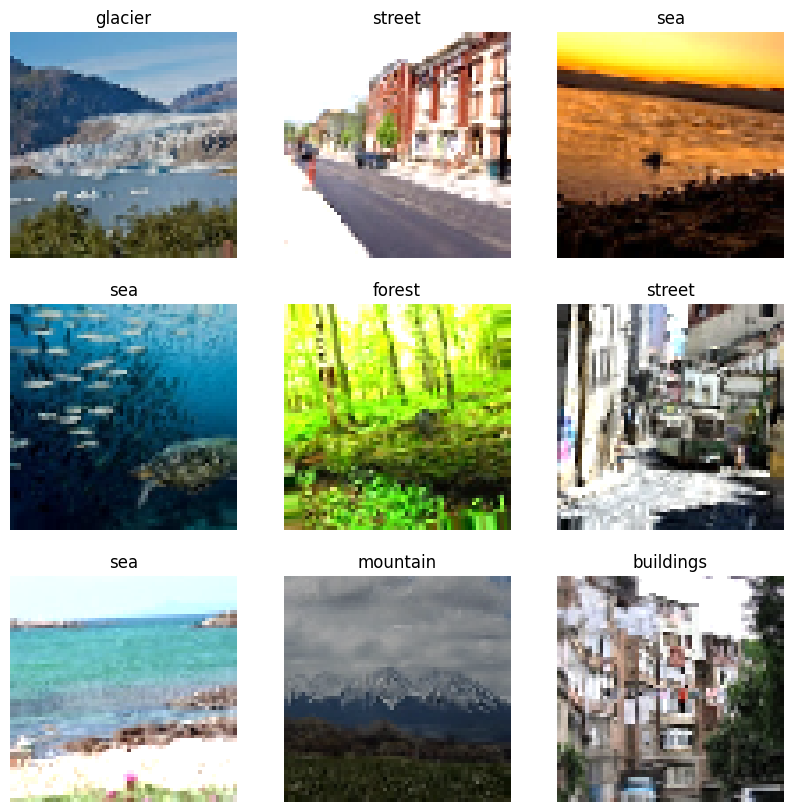

In [8]:
sample_images(train)

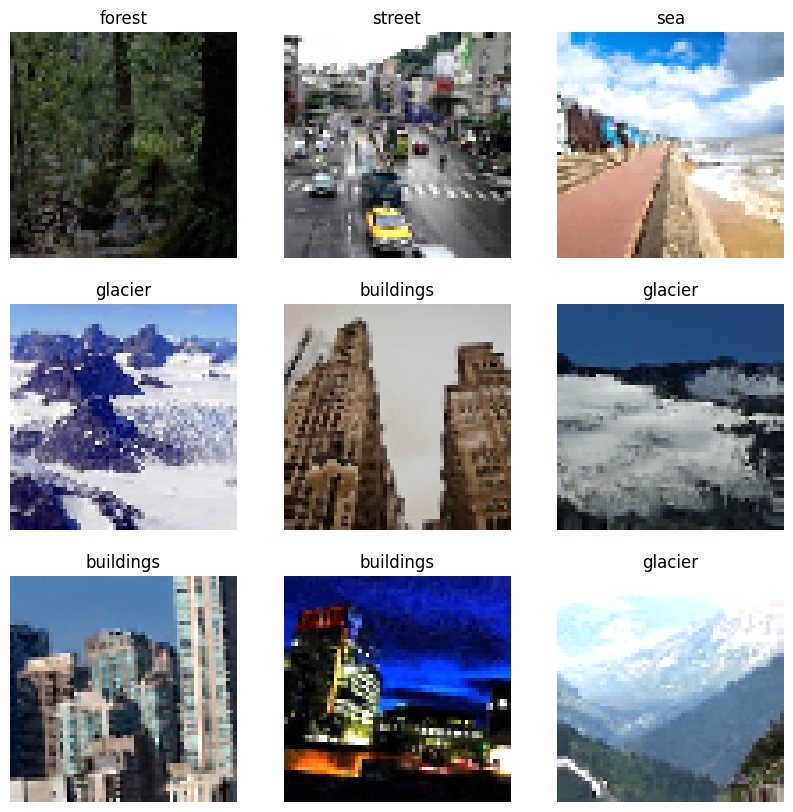

In [9]:
sample_images(validation)

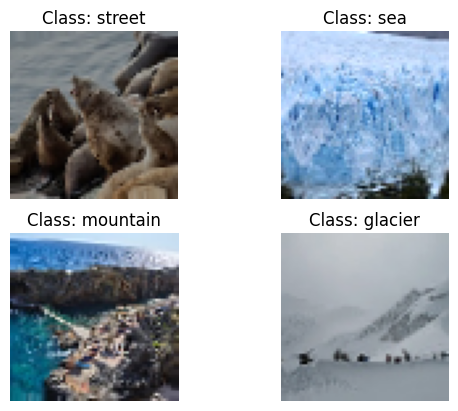

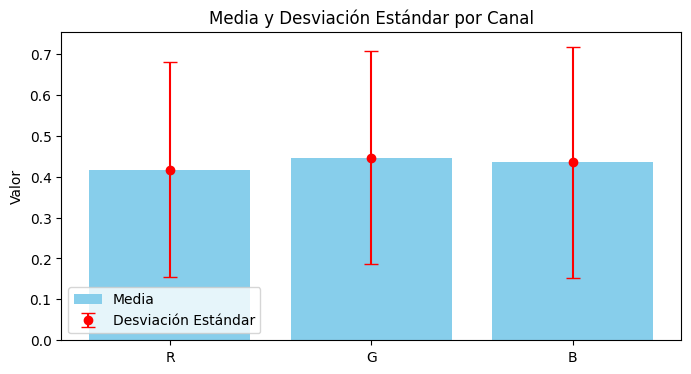

In [10]:
for x_batch, y_batch in train:
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {CLASES[i]}")
        plt.axis('off')
    plt.show()

    mean = np.mean(x_batch, axis=(0, 1, 2))
    std = np.std(x_batch, axis=(0, 1, 2))

    plt.figure(figsize=(8, 4))
    channels = ['R', 'G', 'B']
    
    plt.bar(channels, mean, color='skyblue', label='Media')
    plt.errorbar(channels, mean, yerr=std, fmt='o', color='red', label='Desviación Estándar', capsize=5)
    plt.ylabel("Valor")
    plt.title("Media y Desviación Estándar por Canal")
    plt.legend()
    plt.show()
    break

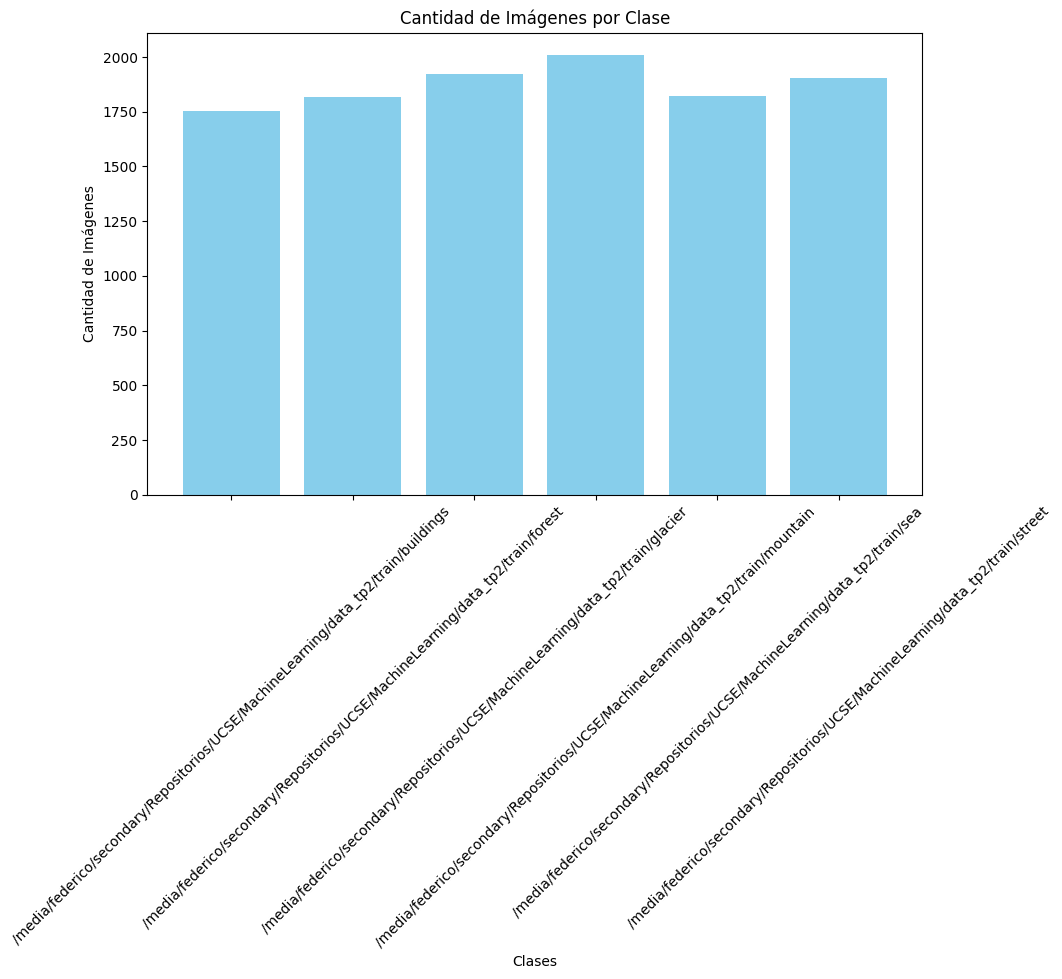

In [11]:
contador_imagenes = {}
for subcarpeta, _, _ in os.walk(TRAIN_DIR):
    imagenes = tf.io.gfile.glob(os.path.join(subcarpeta, "*.jpg"))
    contador_imagenes[subcarpeta] = len(imagenes)

clasesplt = []
cantidades = []

for clase, cantidad in contador_imagenes.items():
        partes = clase.split('\\')
        clases = partes[-1].split(".")[0]      
        clasesplt.append(clases)
        cantidades.append(cantidad)

clasesplt.pop(0)
cantidades.pop(0)
plt.figure(figsize=(10, 6))
plt.bar(clasesplt, cantidades, color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Cantidad de Imágenes por Clase')
plt.xticks(rotation=45)
plt.show()

# Modelado de Redes Neuronales

In [12]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)
input_shape

(64, 64, 3)

## MLP

In [13]:
mlp = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CLASES), activation='softmax'),
])

In [14]:
mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [15]:
mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     6,144,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,147,506 (23.45 MB)

 Trainable params: 6,147,506 (23.45 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos la red, pero por una cuestión teórica, ya suponemos que este tipo de redes no es óptima para problemas de imágenes

Los resultados son un desastre, está underfitteando. En la primer etapa da casi la misma medición de accuracy que en la quinta

## Red Convolucional

Al principio probamos con los parámetros tal cual están en el notebook de ejemplo de la materia, teniendo una accuracy en validation de 0.67 y de 0.68 en train

In [16]:
convolutional = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(CLASES), activation='softmax'),
])

In [17]:
convolutional.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [18]:
convolutional.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 61, 10)     │           490 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 61, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 10)     │         1,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 58, 58, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       196,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,806 (776.59 KB)

 Trainable params: 198,806 (776.59 KB)

 Non-trainable params: 0 (0.00 B)

Agregamos algunas mejoras:
- Más cantidad de filtros, y los vamos aumentando con cada capa
- Reducimos el kernel para que sea más chico y encuentre detalles más finos
- Aumentamos el dropout para compensar el overfitting que podría sumar el aumentar los filtros y reducir el kernel
- Cambiamos el método de pooling de Flatten a GlobalAveragePooling2D (por lo que investigamos anda mejor con imágenes)
- Incrementamos la cantidad de neuronas (puede aportar también al overfitting)
- Usamos relu en lugar de tanh como función de activación en la capa Densa antes de la salida
- Agregamos BatchNormalization entre cada capa

In [19]:
convolutional2 = Sequential([
    Input(shape=input_shape),

    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Convolution2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(len(CLASES), activation='softmax'),
])

In [20]:
convolutional2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [21]:
convolutional2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,734 (506.77 KB)

 Trainable params: 128,774 (503.02 KB)

 Non-trainable params: 960 (3.75 KB)

### Entrenamiento

In [22]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

## Transfer Learning

### VGG16

In [24]:
# Convolucional usando convoluciones ya entrenadas de VGG16
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_vgg16 = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(CLASES), activation='softmax'),
])

In [25]:
model_vgg16.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [26]:
model_vgg16.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,930,294 (56.95 MB)

 Trainable params: 215,606 (842.21 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [28]:
history = model_vgg16.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

Epoch 1/5


/media/federico/secondary/Repositorios/UCSE/MachineLearning/UCSE-2024-ML-TP2/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 110s 309ms/step - accuracy: 0.6883 - loss: 0.8154 - val_accuracy: 0.7721 - val_loss: 0.6082
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.7985 - loss: 0.5492 - val_accuracy: 0.7750 - val_loss: 0.6603
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 108s 308ms/step - accuracy: 0.8264 - loss: 0.4696 - val_accuracy: 0.8010 - val_loss: 0.5500
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 110s 312ms/step - accuracy: 0.8363 - loss: 0.4421 - val_accuracy: 0.7978 - val_loss: 0.5791
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 130s 369ms/step - accuracy: 0.8410 - loss: 0.4123 - val_accuracy: 0.7839 - val_loss: 0.5921


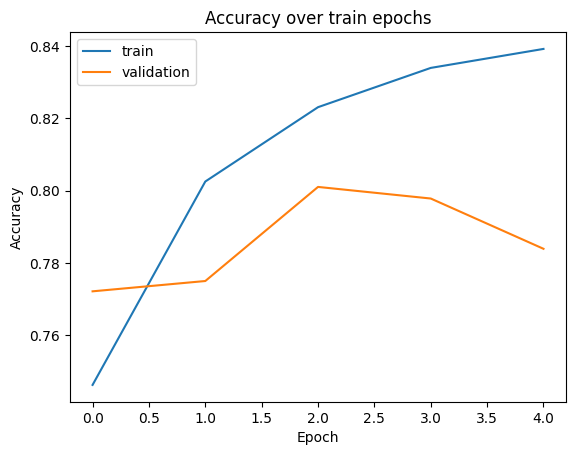

In [29]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### MobileNetV2

Usamos este modelo pre-entrenado porque vimos que consumía pocos recursos, y ya que no tenemos placa gráfica, puede ahorrarnos tiempo

In [34]:
# Cargamos MobileNetV2, sin la capa superior (clasificación) y la congelamos
base_model = MobileNetV2(
    weights='imagenet',      # Usamos pesos preentrenados en ImageNet
    include_top=False,       # Excluimos la capa de clasificación original
    input_shape=input_shape
)
base_model.trainable = False  # Congelamos el modelo base para entrenar solo las capas personalizadas al inicio

# Construimos el modelo agregando capas personalizadas encima del modelo base
model_mobilenetv2 = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),  # Capa densa personalizada para procesar las características
    Dropout(0.5),                   # Dropout para regularización
    Dense(len(CLASES), activation='softmax')  # Capa de salida con softmax para clasificación multi-clase
])

# Compilamos el modelo
model_mobilenetv2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/tmp/ipykernel_101133/227638009.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [36]:
# Entrenamos solo las capas personalizadas con el modelo base congelado
history = model_mobilenetv2.fit(
    train,
    batch_size=16,
    validation_data=validation,
    epochs=10,  # Comenzamos con unas pocas épocas, se puede ajustar según sea necesario
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 36s 94ms/step - accuracy: 0.6365 - loss: 1.0731 - val_accuracy: 0.7589 - val_loss: 0.6344
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.7422 - loss: 0.7075 - val_accuracy: 0.7814 - val_loss: 0.6028
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.7610 - loss: 0.6539 - val_accuracy: 0.7685 - val_loss: 0.6002
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.7755 - loss: 0.6104 - val_accuracy: 0.7892 - val_loss: 0.6045
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.7801 - loss: 0.5957 - val_accuracy: 0.7714 - val_loss: 0.5872
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.7853 - loss: 0.5796 - val_accuracy: 0.7953 - val_loss: 0.5733
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.7963 - loss: 0.5551 - val_accuracy: 0.7907 - val_loss: 0.5864
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.7945 - loss: 0.5538 - 